In [1]:

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import Dataset, DataLoader

In [40]:
sequences = []

with open("/content/1000_calls.txt", "r") as f:
    for line in f:
        if line.strip():
            seq = list(map(int, line.strip().split(',')))
            sequences.append(seq)

print("Total sequences:", len(sequences))

Total sequences: 7107


In [41]:

print("First sequence length:", len(sequences[0]))
print("First 10 numbers:", sequences[0][:10])

First sequence length: 287
First 10 numbers: [292, 291, 292, 291, 291, 291, 291, 291, 291, 291]


In [42]:
labels = []

with open("/content/labels.txt", "r") as f:
    for line in f:
        if line.strip():
            labels.append(line.strip())

print("Total labels:", len(labels))

Total labels: 7107


In [43]:
print(len(sequences), len(labels))

7107 7107


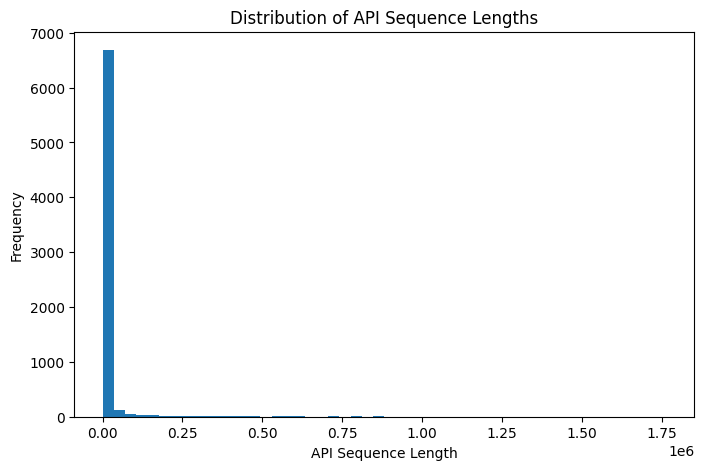

In [64]:
import matplotlib.pyplot as plt

# Compute sequence lengths
seq_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8,5))
plt.hist(seq_lengths, bins=50)
plt.xlabel("API Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of API Sequence Lengths")
plt.show()

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels)

print("Classes:", le.classes_)
print("Number of classes:", len(le.classes_))

Classes: ['Adware' 'Backdoor' 'Downloader' 'Dropper' 'Spyware' 'Trojan' 'Virus'
 'Worms']
Number of classes: 8


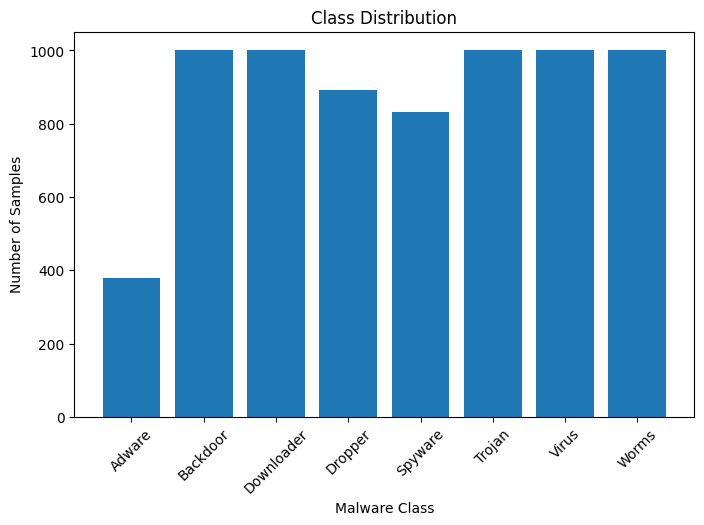

In [66]:
import numpy as np

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(le.classes_, counts)
plt.xticks(rotation=45)
plt.xlabel("Malware Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

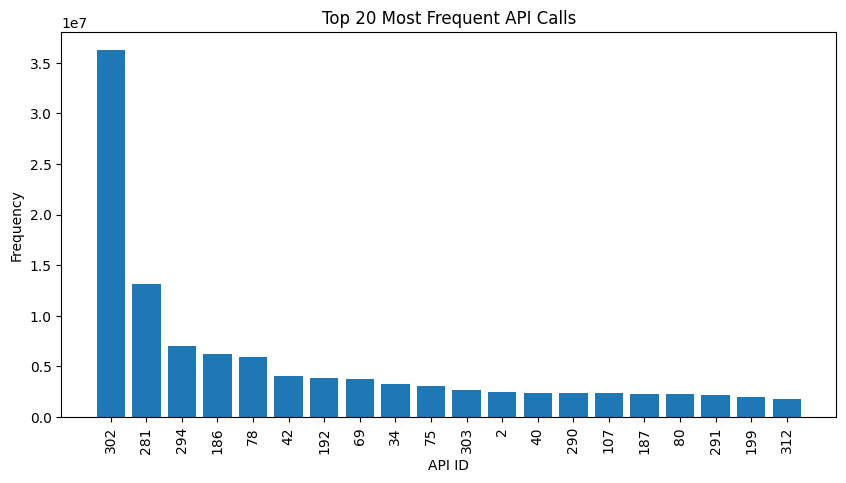

In [67]:
from collections import Counter

all_apis = [api for seq in sequences for api in seq]
api_counts = Counter(all_apis)

top_apis = api_counts.most_common(20)

apis = [str(x[0]) for x in top_apis]
counts = [x[1] for x in top_apis]

plt.figure(figsize=(10,5))
plt.bar(apis, counts)
plt.xlabel("API ID")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent API Calls")
plt.xticks(rotation=90)
plt.show()

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500   # can tune later

X = pad_sequences(
    sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

print("Shape:", X.shape)

Shape: (7107, 500)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


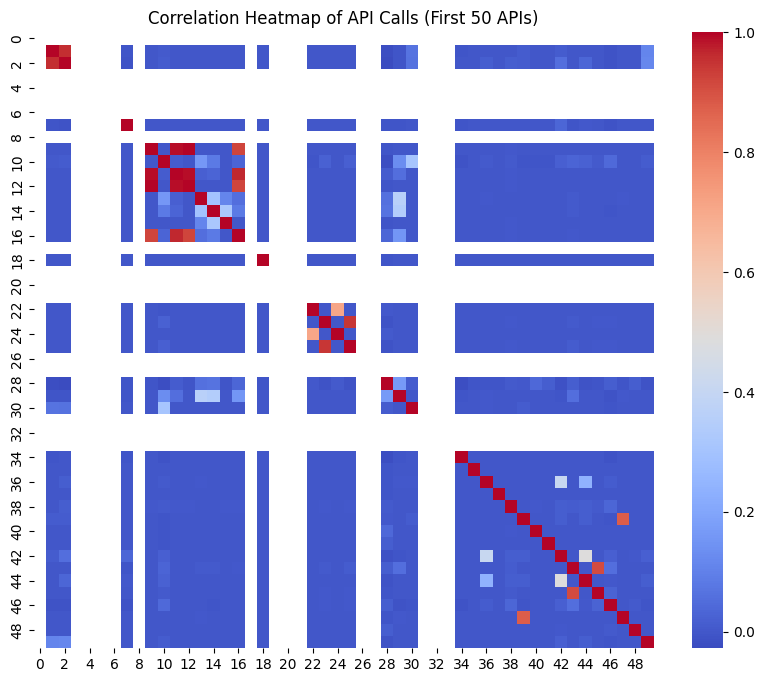

In [65]:
import seaborn as sns
import numpy as np

# Convert sequences into frequency matrix
X_freq = np.zeros((len(sequences), vocab_size))

for i, seq in enumerate(sequences):
    for api in seq:
        X_freq[i][api] += 1

# Correlation matrix (limit to first 50 APIs to keep plot readable)
corr_matrix = np.corrcoef(X_freq[:, :50].T)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Correlation Heatmap of API Calls (First 50 APIs)")
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5685, 500)
Test shape: (1422, 500)


In [47]:
vocab_size = max([max(seq) for seq in sequences]) + 1
print("Vocab size:", vocab_size)

Vocab size: 341


In [48]:
import torch

X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [49]:
from torch.utils.data import Dataset, DataLoader

class MalwareDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MalwareDataset(X_train, y_train)
test_dataset = MalwareDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [50]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [51]:
model = LSTMClassifier(
    vocab_size=341,
    embed_dim=128,
    hidden_dim=128,
    num_classes=8
)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)

Using device: cuda


In [54]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {total_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")

Epoch 1/5
Loss: 174.0749
Train Accuracy: 0.2262
Epoch 2/5
Loss: 163.0217
Train Accuracy: 0.2851
Epoch 3/5
Loss: 158.6932
Train Accuracy: 0.3080
Epoch 4/5
Loss: 154.4139
Train Accuracy: 0.3214
Epoch 5/5
Loss: 150.5861
Train Accuracy: 0.3398


In [55]:
model.eval()
correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == y_batch).sum().item()

test_acc = correct / len(test_loader.dataset)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.32208157524613223


***GRU***

In [56]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return out

In [57]:
model = GRUClassifier(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,
    num_classes=8
).to(device)

In [58]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {total_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")

Epoch 1/5
Loss: 186.3120
Train Accuracy: 0.1574
Epoch 2/5
Loss: 186.3100
Train Accuracy: 0.1574
Epoch 3/5
Loss: 186.3170
Train Accuracy: 0.1574
Epoch 4/5
Loss: 186.3168
Train Accuracy: 0.1574
Epoch 5/5
Loss: 186.3133
Train Accuracy: 0.1574


In [59]:
model.eval()
correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == y_batch).sum().item()

test_acc = correct / len(test_loader.dataset)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.1540084388185654


***1D CNN***

In [60]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)              # (batch, seq, embed)
        x = x.permute(0, 2, 1)             # (batch, embed, seq)
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        out = self.fc(x)
        return out

In [61]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {total_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")

Epoch 1/5
Loss: 186.3158
Train Accuracy: 0.1574
Epoch 2/5
Loss: 186.2979
Train Accuracy: 0.1574
Epoch 3/5
Loss: 186.3201
Train Accuracy: 0.1574
Epoch 4/5
Loss: 186.3097
Train Accuracy: 0.1574
Epoch 5/5
Loss: 186.3186
Train Accuracy: 0.1574


In [62]:
model.eval()
correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == y_batch).sum().item()

test_acc = correct / len(test_loader.dataset)

print("Test Accuracy:", test_acc)

Test Accuracy: 0.1540084388185654


***RandomForest***

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

seq_strings = [" ".join(map(str, seq)) for seq in sequences]

vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(seq_strings)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_counts, y)

print("RF Accuracy:", rf.score(X_counts, y))

RF Accuracy: 0.9936682144364711
